# **Import Libraries** 
***


In [137]:
import pandas as pd
import unicodeit
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display,Markdown
import statsmodels.api as sm
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Attention, Concatenate, Flatten
from keras.models import Model



In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Input, Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


In [25]:
# define random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)

## **1. Load the "Individual household electric power consumption" dataset** 
***

In [26]:
# first define datatypes for the columns
dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

'''
fetch the dataset (acknowledging that the seperator is ';' and missing values are marked as '?'
'''

file_path = 'household_power_consumption.txt'
power_consumption_df = pd.read_csv(file_path, sep=';',dtype=dtypes,na_values='?')
power_consumption_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We can see that we have 9 features:
* Date
* Time
* Global_active_power
* Global_reactive_power
* Voltage
* Global_intensity
* Sub_metering_1
* Sub_metering_2
* Sub_metering_3

However, our target (active energy consumed every minute) is  not specified in the dataset. we will define "Global_active_power" as our target. Also, we would like to combine date and time to a one feature called: "datetime".

In [27]:
# combine date and time into datetime
power_consumption_df['Datetime'] = pd.to_datetime(power_consumption_df['Date'] + ' ' + power_consumption_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as index
power_consumption_df.set_index('Datetime', inplace=True)

# Drop the original Date and TIme columns
power_consumption_df.drop(columns=['Date', 'Time'], inplace=True)
power_consumption_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## 2. **EDA**
***

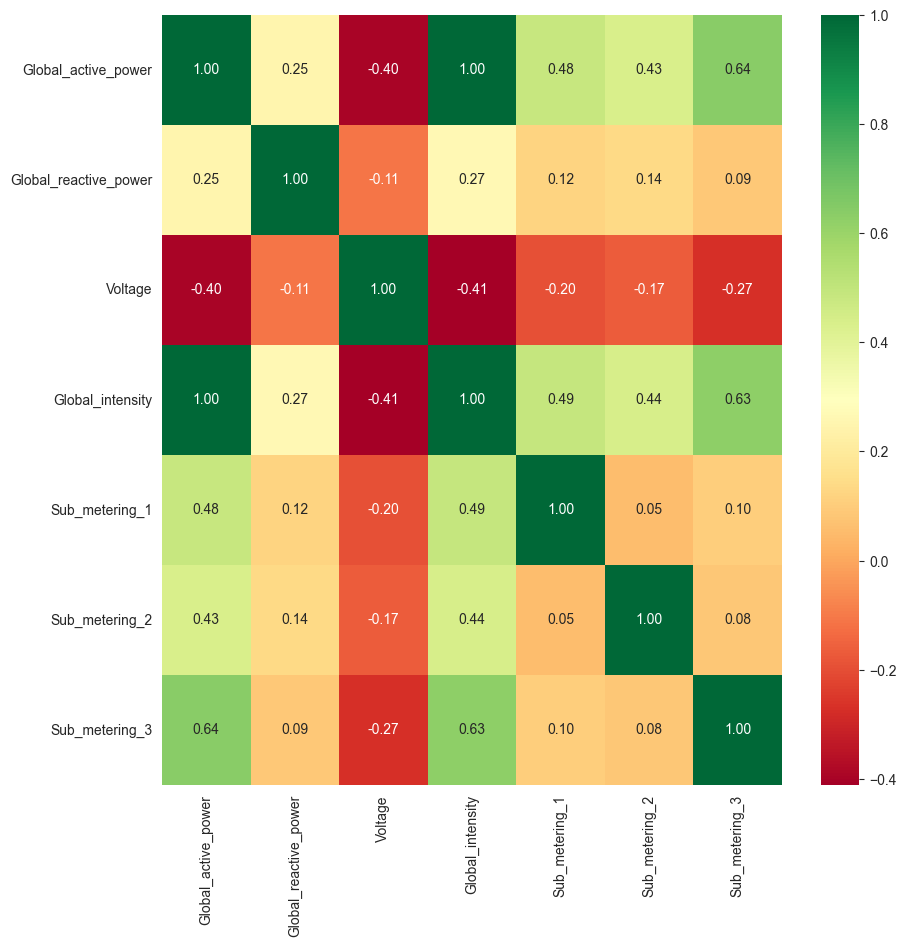

In [28]:
# Create a correlation plot to find the correlation between columns
plt.figure(figsize=(10, 10)) 
sns.heatmap(power_consumption_df.corr(method='pearson'),  
            annot=True,  
            cmap='RdYlGn',  
            fmt='.2f')  
plt.show()

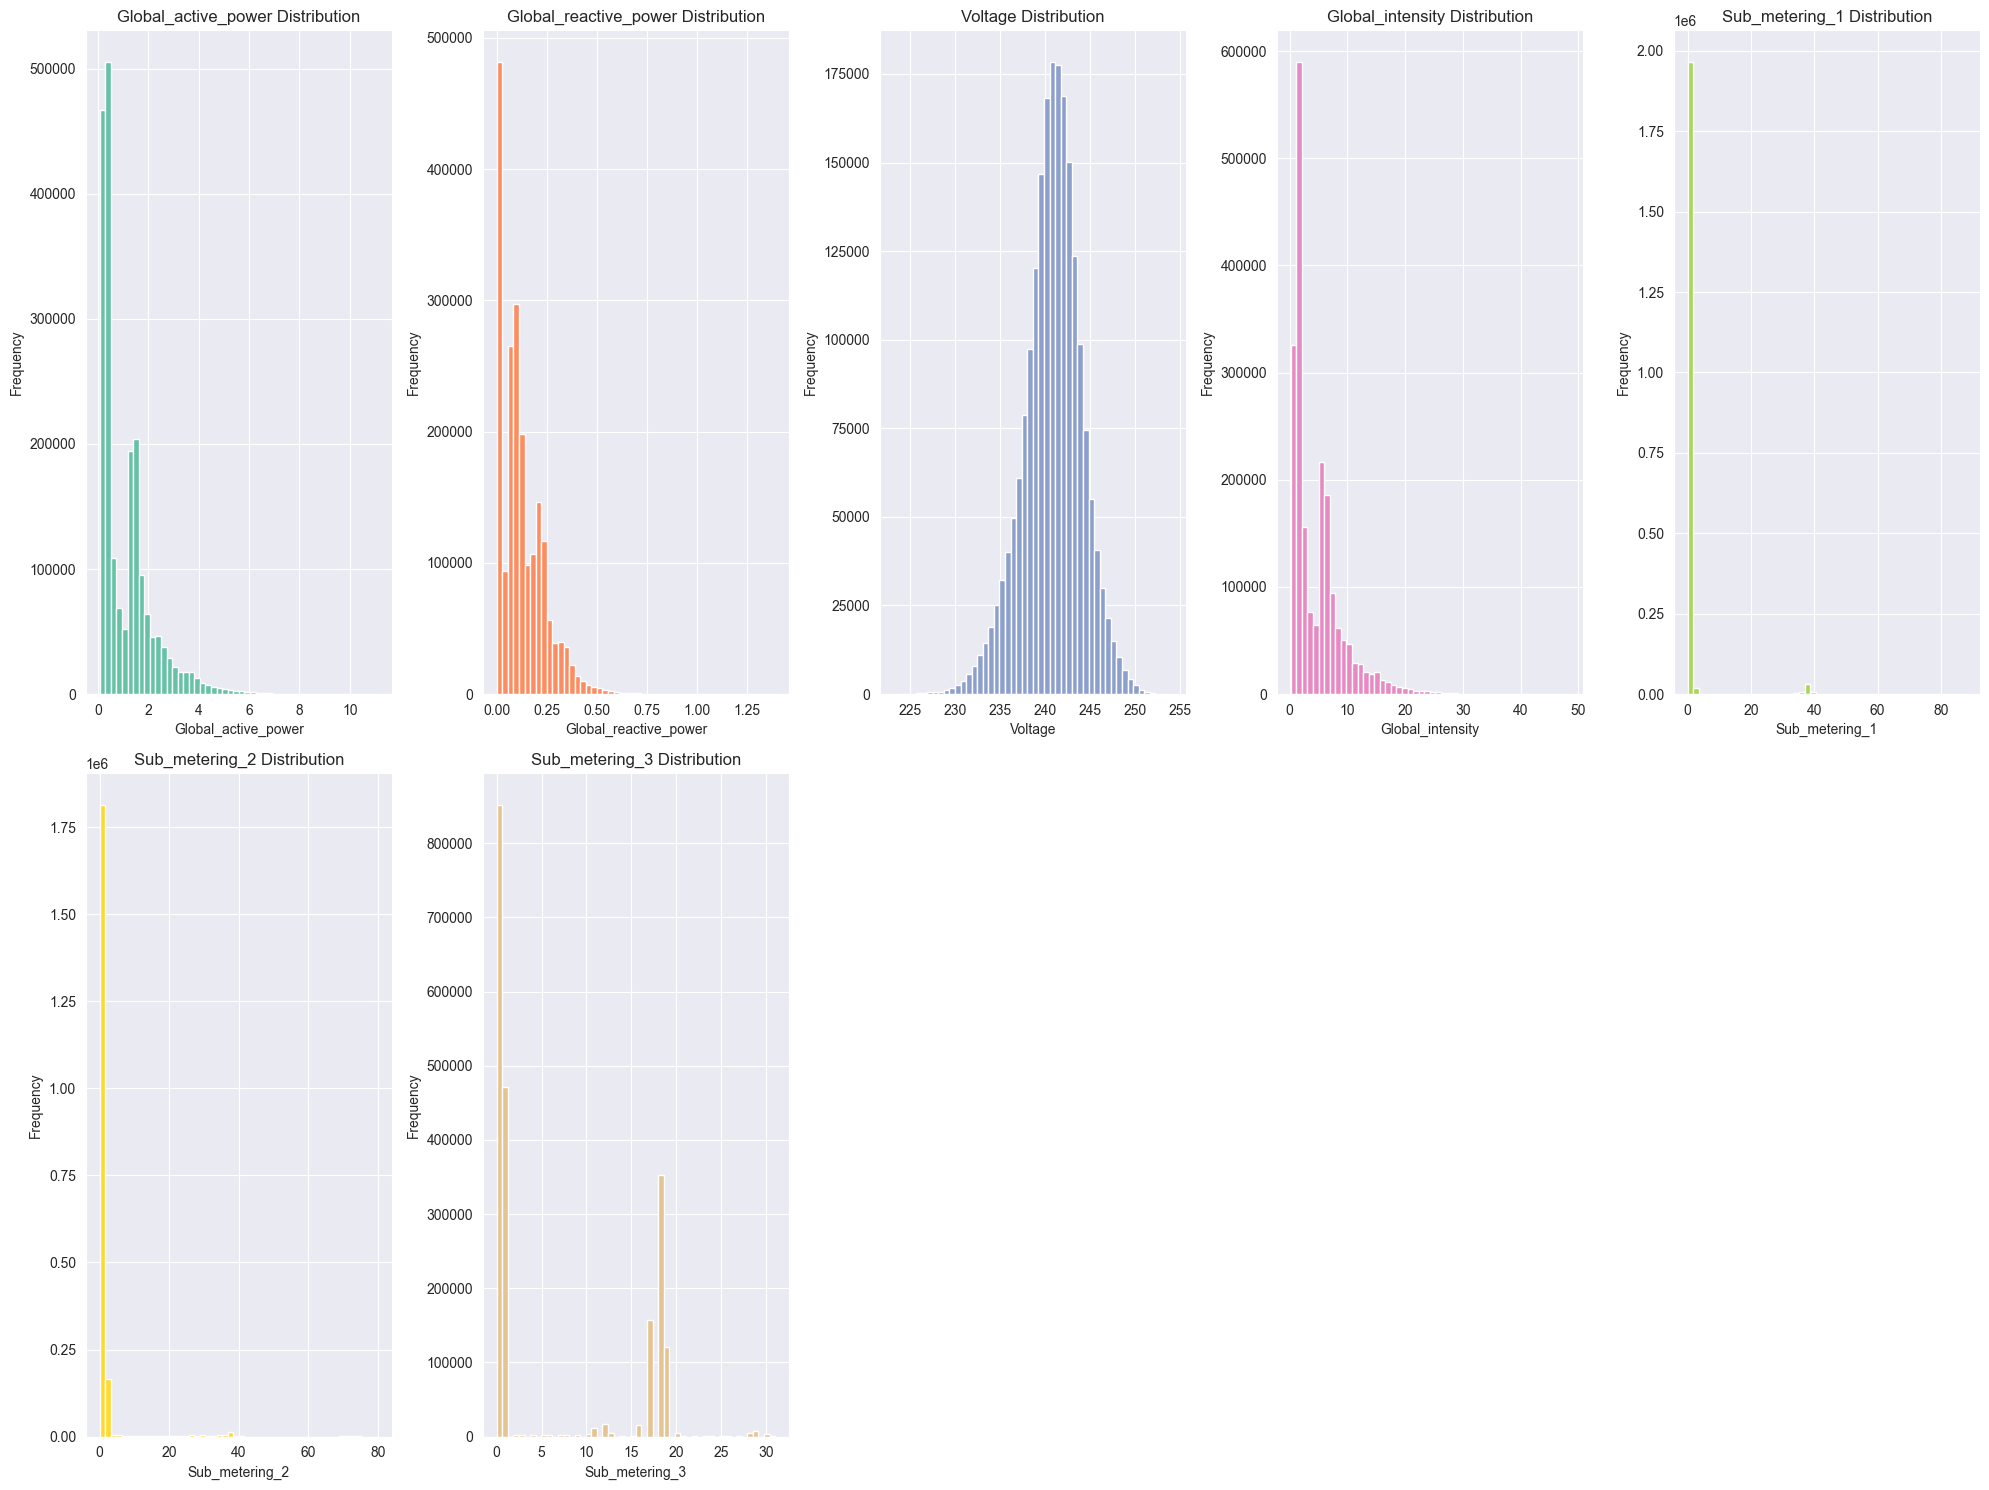

In [29]:
# Define colors for plotting
colors = sns.color_palette("Set2", len(power_consumption_df .columns))

# Define number of plots per row
plots_per_row = 5

# Calculate number of rows needed for the subplot grid
num_rows = len(power_consumption_df .columns) // plots_per_row + (len(power_consumption_df .columns) % plots_per_row > 0)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, 15))

# Flatten the axes array
axes = axes.flatten()

# Plot histograms for each column
for i, (col, color) in enumerate(zip(power_consumption_df .columns, colors)):
    power_consumption_df [col].hist(bins=50, ax=axes[i], color=color)
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display plot
plt.tight_layout()
plt.show()

From the distributions we can draw the following conclusions:
* The Global Active power seems to be consisted of two different normal distributions, one centered near 0, and the other centered at approximately 1.7. That could imply some different seasonal patterns within the year, one with lower power consumption, and the other - with a higher one.

* The Global reactive power seems to be less sparse, and will most likely be near 0. It implies that the electricity network is efficient and doesn't suffer from many losses :) .

* The voltage is clearly normally distributed with a mean around 240V (which makes sense since it's a French household). The voltage consumption is sparse, and that could be explained by different voltage consumptions from different appliances.

* Just like Global Active Power, the Global Intensity also seems to be consisted of two normal distributions which can imply different seasonal patterns - one centered at approximately 0 and one centered at approximately 5 .

* Sub_metering_1, Sub_metering_2, Sub_metering_3: High frequency of zero values indicates many periods with no sub-metered energy usage, with some occasional spikes.

### Interpretation: ###
***

* Global_active_power: Skewed to the right, indicating that most values are low, but there are occasional high values.
* Voltage: More normally distributed, showing stable voltage supply.
* Sub_metering_1, Sub_metering_2, Sub_metering_3: High frequency of zero values indicates many periods with no sub-metered energy usage, with some occasional spikes.

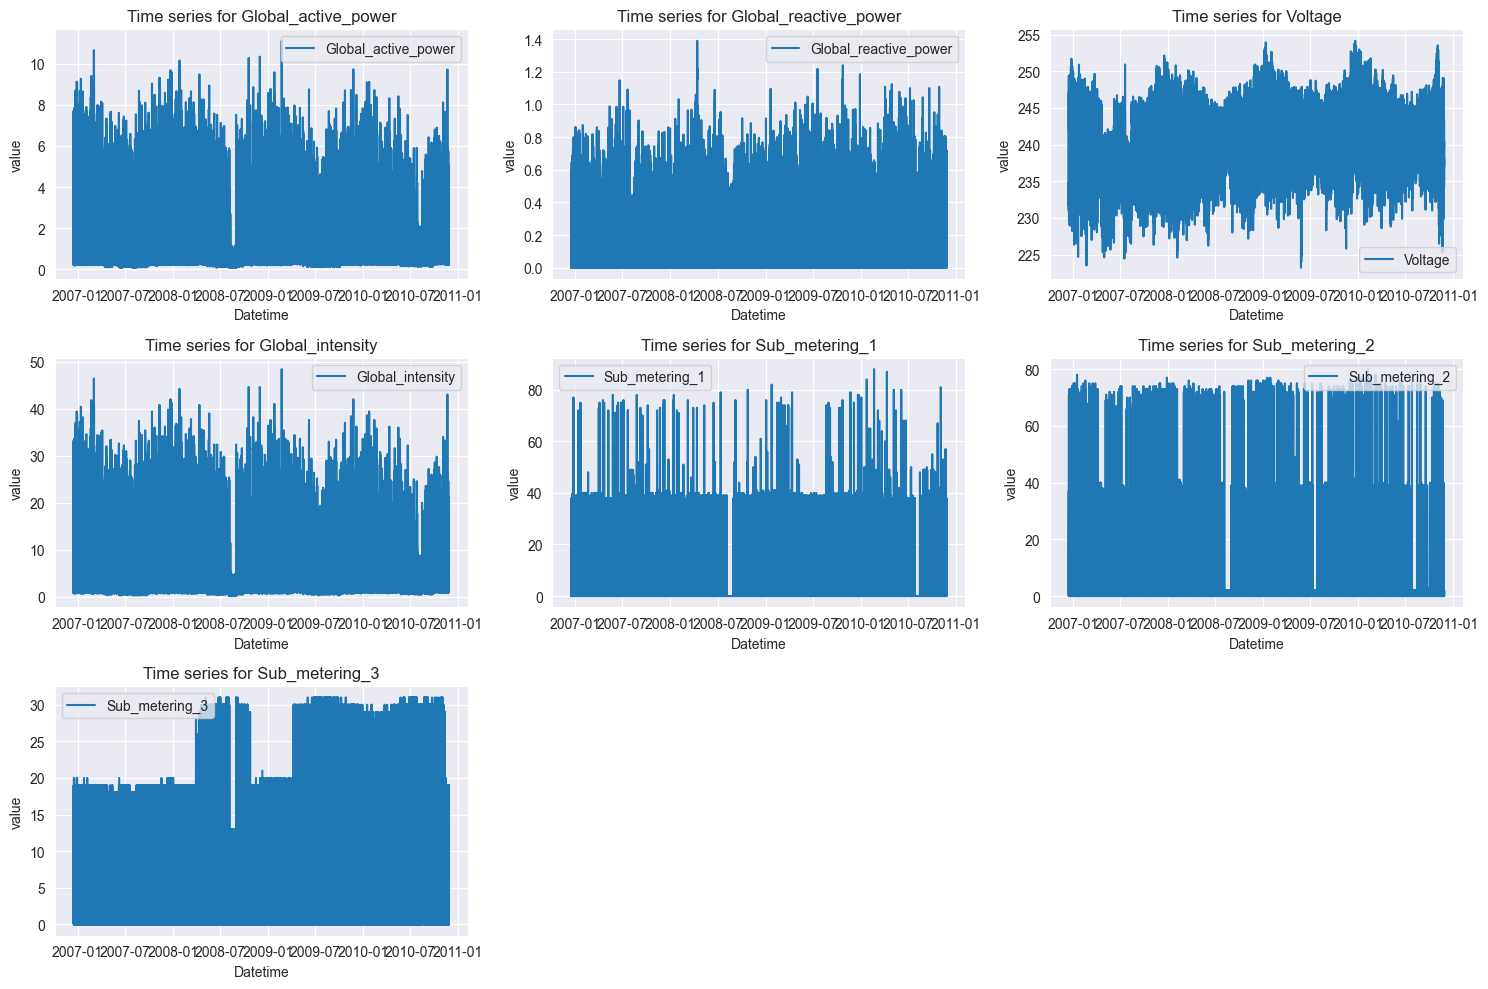

In [30]:
def visualize_time_trends(data,columns_to_omit=None,resample=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))
    if columns_to_omit is  None:
        columns_to_omit = []

    i = j = 0

    for column in data.columns:
        if column not in columns_to_omit:
            if resample is None:
                axes[i, j].plot(data[column], label=column)

            else:
                axes[i, j].plot(data[column].resample(resample).mean(), label=column)

            axes[i, j].set_title(f'Time series for {column}')
            axes[i, j].set_xlabel('Datetime')
            axes[i, j].set_ylabel(f"value")
            axes[i,j].legend()
            j += 1

            if j == num_cols:
                j = 0
                i += 1

    if math.sqrt(num_plots) < num_cols:
        remainder = (num_cols ** 2) % num_plots
        for i in range(1, remainder + 1, 1):
            axes[-1,-1 * i].axis('off') # hide the last plots

    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_time_trends(power_consumption_df)

According to the time series trends we can say the following:
1. **Global Active Power**

    * **Seasonality:** It seems like there are strong seasonal patterns with regular peaks and troughs (best appeared in the monthly resampling). This phenomenon could be explained by high power consumption during certain times of the year (for example, hot summer days)
         
   * **Cyclical Patterns:** There may be some longer-term trends, but they are overshadowed and difficult to isolate from the clear seasonal patterns without further analysis.

2. **Global reactive power**
    * **Seasonality:** Similar to Global Active Power, we can see a strong seasonal pattern (which makes sense, since the reactive power are the losses from the electrical appliances of the consumer, so they should have the same seasonality as the active power)
      
    * **Cyclical Patterns:** The same as the active power - longer term trends are less apparent, since there is a strong seasonal pattern.

3. **Voltage** 
    * **Seasonality:** The voltage shows less clear seasonal patterns (it doesn't seem to have a constant period) compared to power consumption, though there are still some periodic fluctuations (it seems clearer in the weekly or monthly resampling)
      
    * **Cyclical Patterns:** If there are any cyclical patterns in the voltage, they are not very prominent.

4. **Global Intensity**
    * **Seasonality:** There is a clear seasonal pattern, with regular fluctuations which again could be explained by periods of higher electricity demand.
      
    * **Cyclical Patterns:** Similar to the Global Active Power, the cyclical trends are less evident due to the dominant seasonal patterns.

5. **Sub Metering 1,2, and 3:** 
    * **Seasonality:** Each sub metering shows distinct seasonal patterns, likely corresponding to specific appliances that have different regular usage cycles.
      
    * **Cyclical Patterns:** Less apparent, as the data is dominated by strong seasonal patterns.



**Conclusion**

This dataset exhibits strong seasonal patterns across most of the features, as well as the target variable (Global_active_power). The seasonal patterns are consistent and predictable, and most likely correspond to higher and lower power demand during different periods of the year.

Cyclical patterns in this dataset are harder to distinguish from the seasonal ones, due to the dominance of the seasonal patterns.

### **Identify and handle missing values and outliers**
***

In [31]:
display(power_consumption_df.isna().sum())
display(Markdown(f'##### {power_consumption_df.isna().sum().iloc[0]/ power_consumption_df.shape[0] * 100}% of the data is missing'))

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

##### 1.2518437457686005% of the data is missing

In [32]:
power_consumption_df_no_missing = power_consumption_df.copy()

for _column in power_consumption_df_no_missing.columns:
    # forward fill the column
    power_consumption_df_no_missing[_column] = power_consumption_df_no_missing[_column].ffill() 

# check for the existence of missing values again
power_consumption_df_no_missing.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that we have filled the missing values and re-calculated our target. let's deal with the outliers. let's make a seasonal decomposition (for example, let's do that to the global_active_power):

In [33]:
power_consumption_df_no_missing = power_consumption_df.copy()

for _column in power_consumption_df_no_missing.columns:
    # forward fill the column
    power_consumption_df_no_missing[_column] = power_consumption_df_no_missing[_column].ffill() 

# check for the existence of missing values again
power_consumption_df_no_missing.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that we have filled the missing values and re-calculated our target. let's deal with the outliers. let's make a seasonal decomposition (for example, let's do that to the global_active_power):

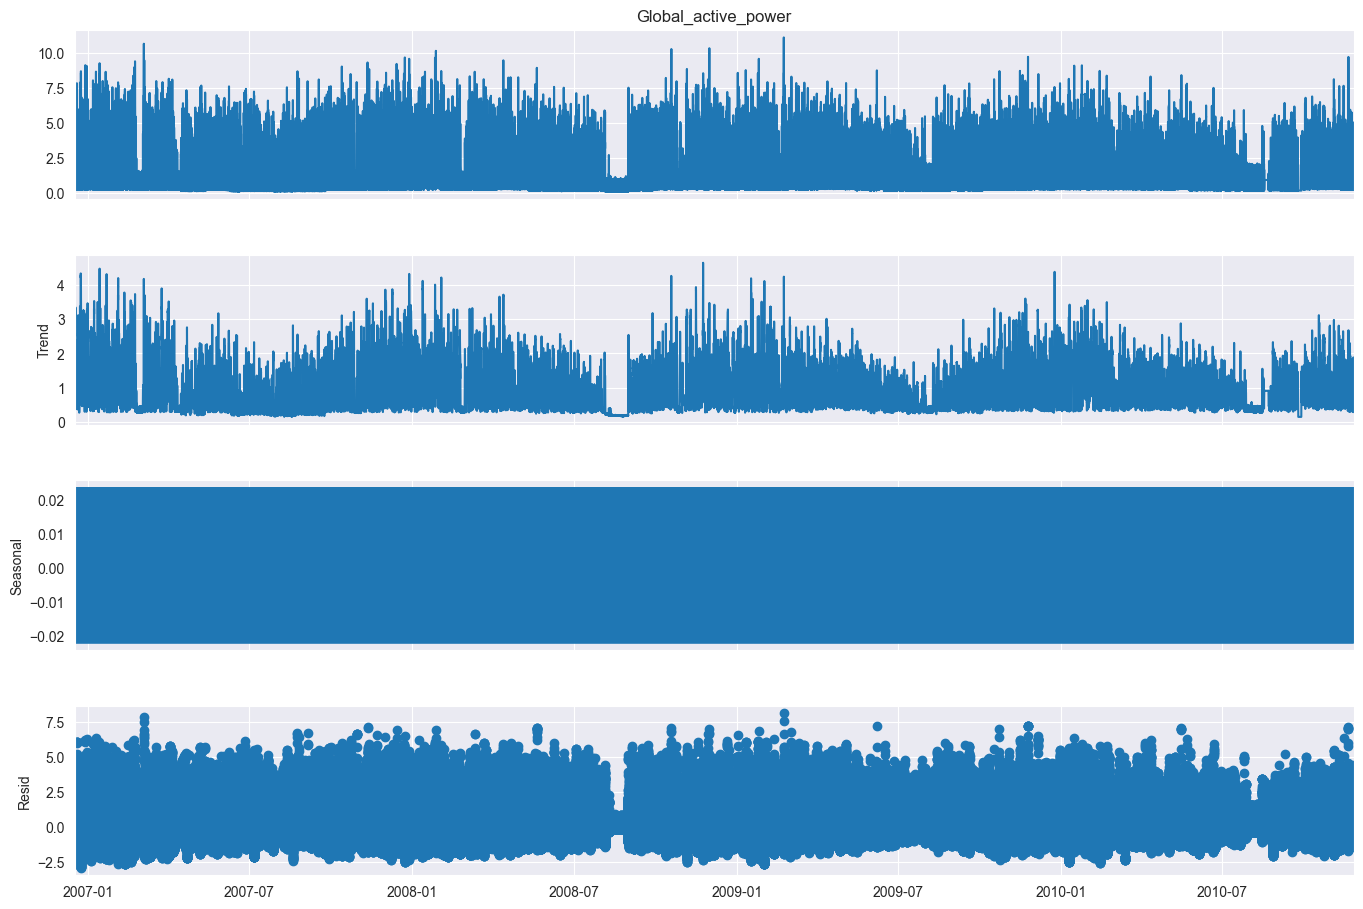

In [34]:
decomposition = sm.tsa.seasonal_decompose(power_consumption_df_no_missing['Global_active_power'],model='additive',period=365)
fig1 = decomposition.plot()
fig1.set_size_inches((15,10))
plt.show()

This decomposition consists of the following:
* **Observed:** The time series as it is (the actual data)
* **Trend:** reveals the long-term increase/decrease in the global_active_power consumption.
* **Seasonal:** The seasonal plot shows recurring patterns, for example: higher consumption during certain times of the month.
* **Residual:** The residual plot displays the noise or irregularities in the data (so we can use that in order to identify the outliers). We wil define an outlier as:
$outlier = resid.mean() \pm 3*resid.std()$
* We will check outliers for our target variable to see if it makes sense (for example - higher power consumption during summer). 

In [35]:
def check_for_outliers(time_series,period,number_of_stds):
    seasonal_decomposition = sm.tsa.seasonal_decompose(time_series,model='additive',period=period)
    residuals = seasonal_decomposition.resid
    outliers_high = residuals[(residuals > residuals.mean() + number_of_stds * residuals.std())]
    outliers_low = residuals[(residuals < residuals.mean() - number_of_stds * residuals.std())]
    return outliers_low.index, outliers_high.index
(low_outliers_dates, high_outliers_dates) = check_for_outliers(time_series=power_consumption_df_no_missing['Global_active_power'],period=365,number_of_stds=3)
display(Markdown(f'##### low_power consumption dates are: {low_outliers_dates}'))
display(Markdown(f'##### high_power consumption dates are: {high_outliers_dates}'))

##### low_power consumption dates are: DatetimeIndex(['2006-12-16 22:31:00', '2006-12-16 22:36:00',
               '2006-12-16 22:41:00', '2006-12-16 22:47:00',
               '2006-12-16 23:03:00', '2006-12-23 00:08:00',
               '2006-12-23 00:13:00', '2006-12-23 05:30:00',
               '2006-12-23 05:35:00', '2006-12-23 05:40:00',
               ...
               '2010-03-13 17:02:00', '2010-03-13 17:03:00',
               '2010-03-13 17:04:00', '2010-03-13 17:05:00',
               '2010-03-13 17:06:00', '2010-03-13 17:07:00',
               '2010-03-13 17:08:00', '2010-03-13 17:09:00',
               '2010-03-13 17:10:00', '2010-03-13 17:11:00'],
              dtype='datetime64[ns]', name='Datetime', length=349, freq=None)

##### high_power consumption dates are: DatetimeIndex(['2006-12-17 01:04:00', '2006-12-17 01:05:00',
               '2006-12-17 01:08:00', '2006-12-17 01:09:00',
               '2006-12-17 01:10:00', '2006-12-17 01:13:00',
               '2006-12-17 01:14:00', '2006-12-17 01:15:00',
               '2006-12-17 01:19:00', '2006-12-17 01:20:00',
               ...
               '2010-11-26 07:32:00', '2010-11-26 07:33:00',
               '2010-11-26 07:34:00', '2010-11-26 07:35:00',
               '2010-11-26 07:36:00', '2010-11-26 07:37:00',
               '2010-11-26 07:38:00', '2010-11-26 07:39:00',
               '2010-11-26 07:40:00', '2010-11-26 07:41:00'],
              dtype='datetime64[ns]', name='Datetime', length=41770, freq=None)

let's see what percentage of the data are these outliers before we make a decision:

In [36]:
display(Markdown(f'##### {(len(low_outliers_dates) + len(high_outliers_dates)) / power_consumption_df_no_missing.shape[0] * 100}% of the data is considered outliers'))

##### 2.029577994843053% of the data is considered outliers

since only 2% of the data is considered outliers, we will decide to drop them:


In [37]:
power_consumption_df_no_missing_no_outliers = power_consumption_df_no_missing.copy()
outliers_to_drop = low_outliers_dates.union(high_outliers_dates)
power_consumption_df_no_missing_no_outliers.drop(outliers_to_drop,inplace=True)
display(power_consumption_df_no_missing_no_outliers)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [55]:
energy= power_consumption_df_no_missing_no_outliers.copy



# Step 3: Implement a Linear Regression Model #
***


Split the data into training and testing sets


In [127]:
# Function to create lagged features
def create_lagged_features(df, columns, lags):
    for column in columns:
        for lag in range(1, lags + 1):
            df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df.dropna()

# Function to split the data into train and test sets (80:20 ratio)
def split_data(df, target_column):
    train_size = int(len(df) * 0.8)
    train, test = df[:train_size], df[train_size:]
    X_train = train.drop(target_column, axis=1)
    y_train = train[target_column]
    X_test = test.drop(target_column, axis=1)
    y_test = test[target_column]
    return X_train, X_test, y_train, y_test

# Function to resample data
def resample_data(df, freq):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")
    return df.resample(freq).mean()

# Function to prepare features and train linear regression model

# Function to prepare features and train linear regression model # 'minutely': 'min','hourly': 'h', 'daily': 'D','monthly': 'ME','weekly': 'W'
def train_and_evaluate_linear_regression(df, target_column, lags, resample_freq='D'):
    # Resample data
    resampled_df = resample_data(df, resample_freq)
    
    # Create lagged features
    columns_selected = ['Global_active_power']
    processed_df = create_lagged_features(resampled_df, columns_selected, lags)
    
    # Drop unwanted columns
    columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
    columns_to_drop = [col for col in columns_to_drop if col in processed_df.columns]
    processed_df = processed_df.drop(columns=columns_to_drop)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(processed_df, target_column)
    
    # Train linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, rmse, r2, y_test, y_pred


# Function to plot actual vs predicted values for different time periods
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    time_periods = [50, 100, 200, 300]
    fig2, axes2 = plt.subplots(2, 2, figsize=(20, 14))
    axes2 = axes2.flatten()

    for i, period in enumerate(time_periods):
        axes2[i].plot(y_test.index[-period:], y_test[-period:], label='Actual', color='blue')
        axes2[i].plot(y_test.index[-period:], y_pred[-period:], label='Predicted', color='red', linestyle='dashed')
        axes2[i].set_title(f'Actual vs Predicted Global Active Power (Last {period} Data Points) - {model_name}')
        axes2[i].set_xlabel('DateTime')
        axes2[i].set_ylabel('Global Active Power (kilowatts)')
        axes2[i].legend()

    plt.tight_layout()
    plt.show()



Linear Regression Model Performance on Original Data:
MSE: 0.0650103822062522
MAE: 0.18978712670084674
RMSE: 0.25497133604829425
R²: 0.34641785780017664


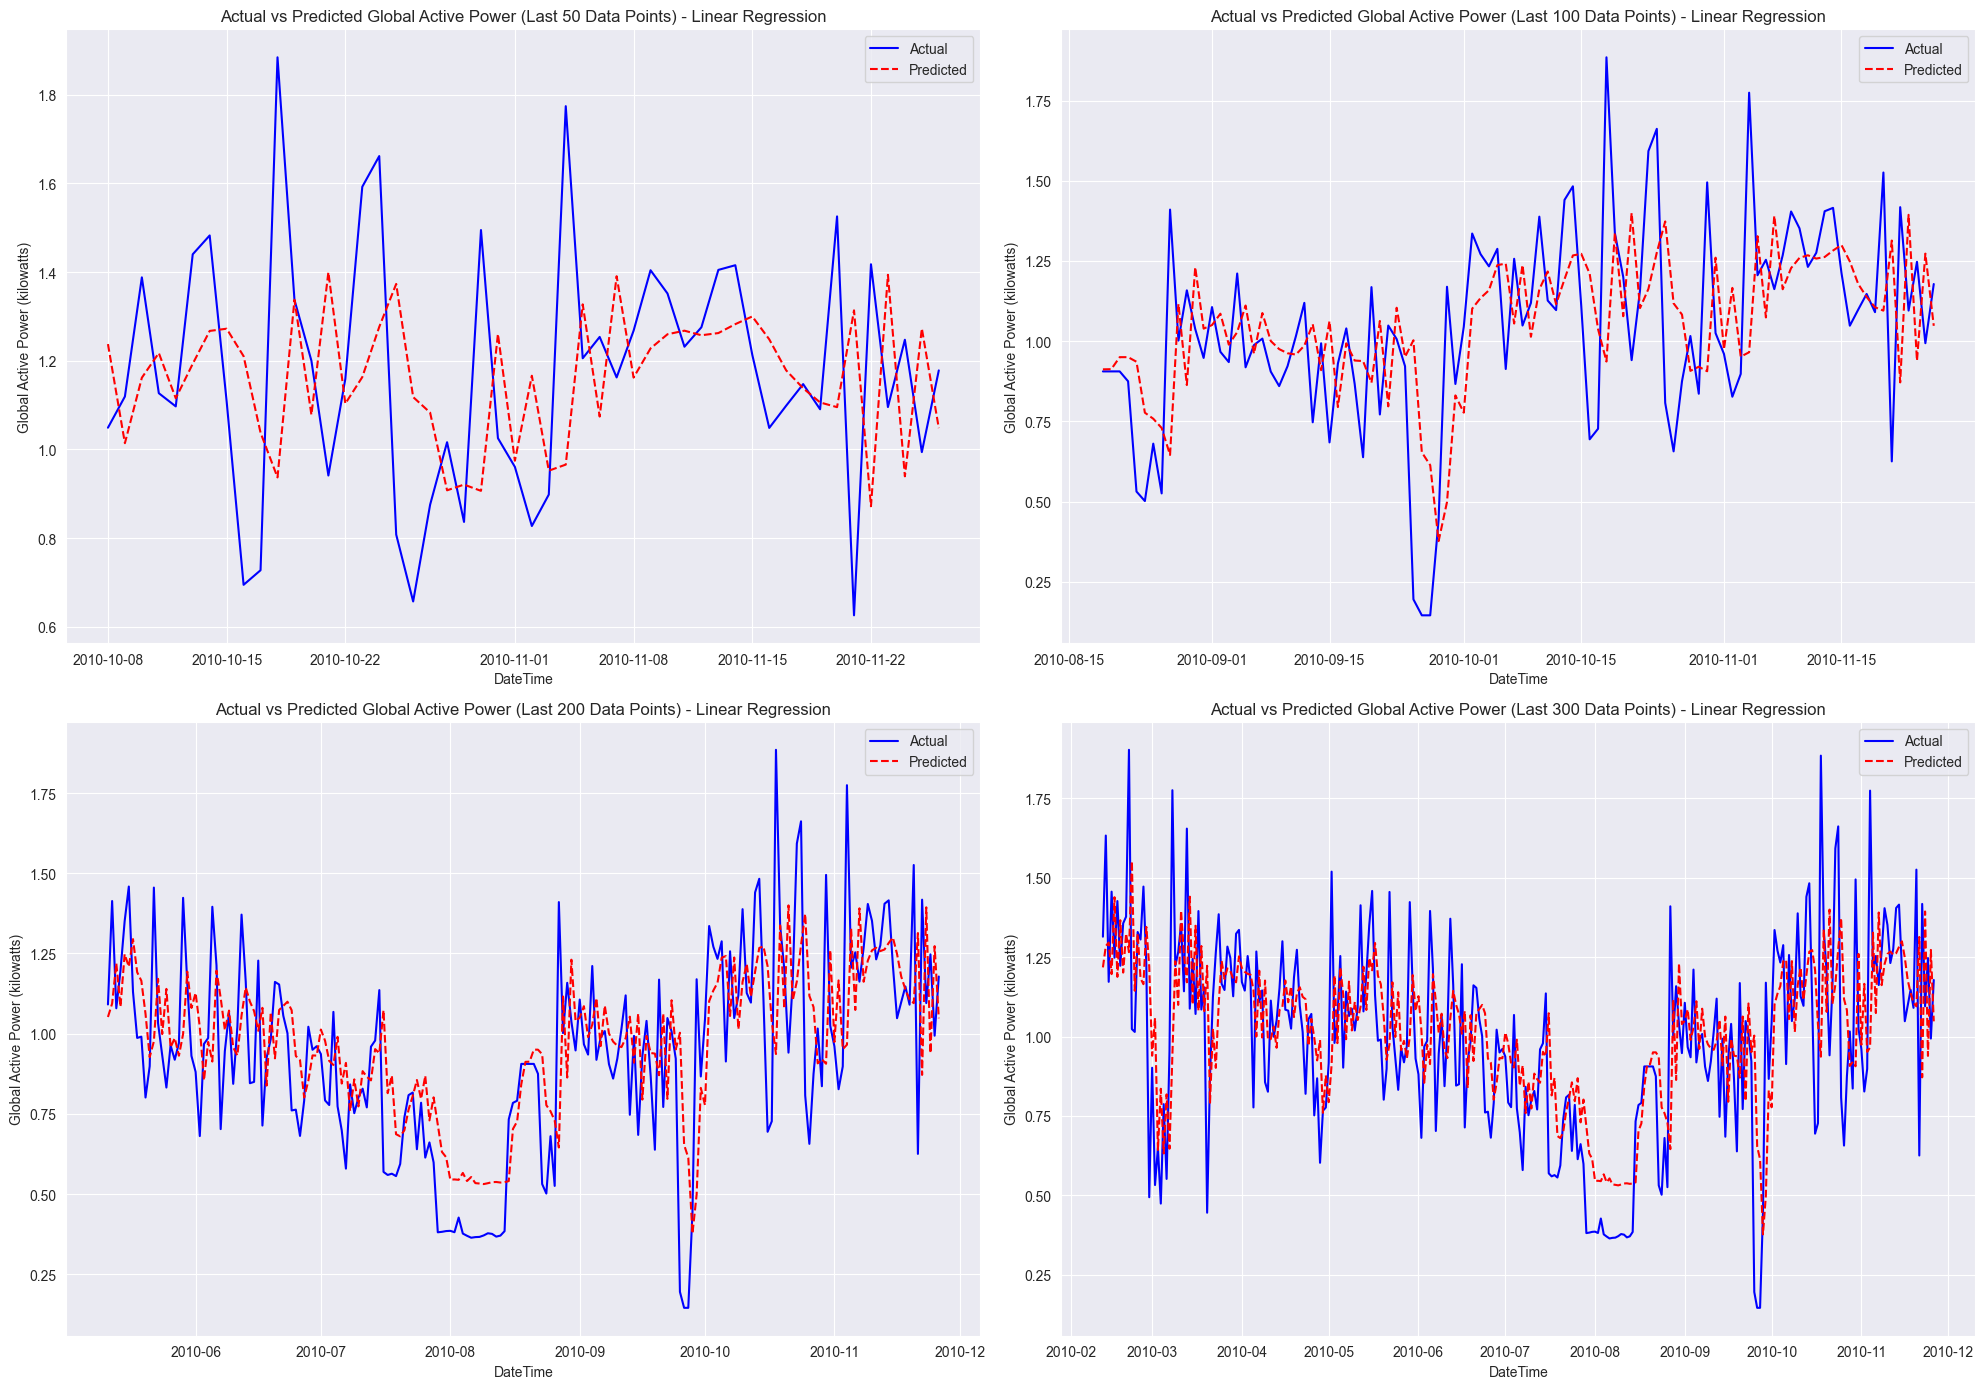

In [128]:

# Define target column and lags
target_column = 'Global_active_power'
lags = 3
resample_freq='min'

# Evaluate linear regression model on the original time interval
mse, mae, rmse, r2, y_test, y_pred = train_and_evaluate_linear_regression(power_consumption_df_no_missing, target_column, lags,resample_freq)

print("\nLinear Regression Model Performance on Original Data:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

plot_actual_vs_predicted(y_test, y_pred, 'Linear Regression')

# RNN #
***

C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12971/12971 ━━━━━━━━━━━━━━━━━━━━ 9s 692us/step


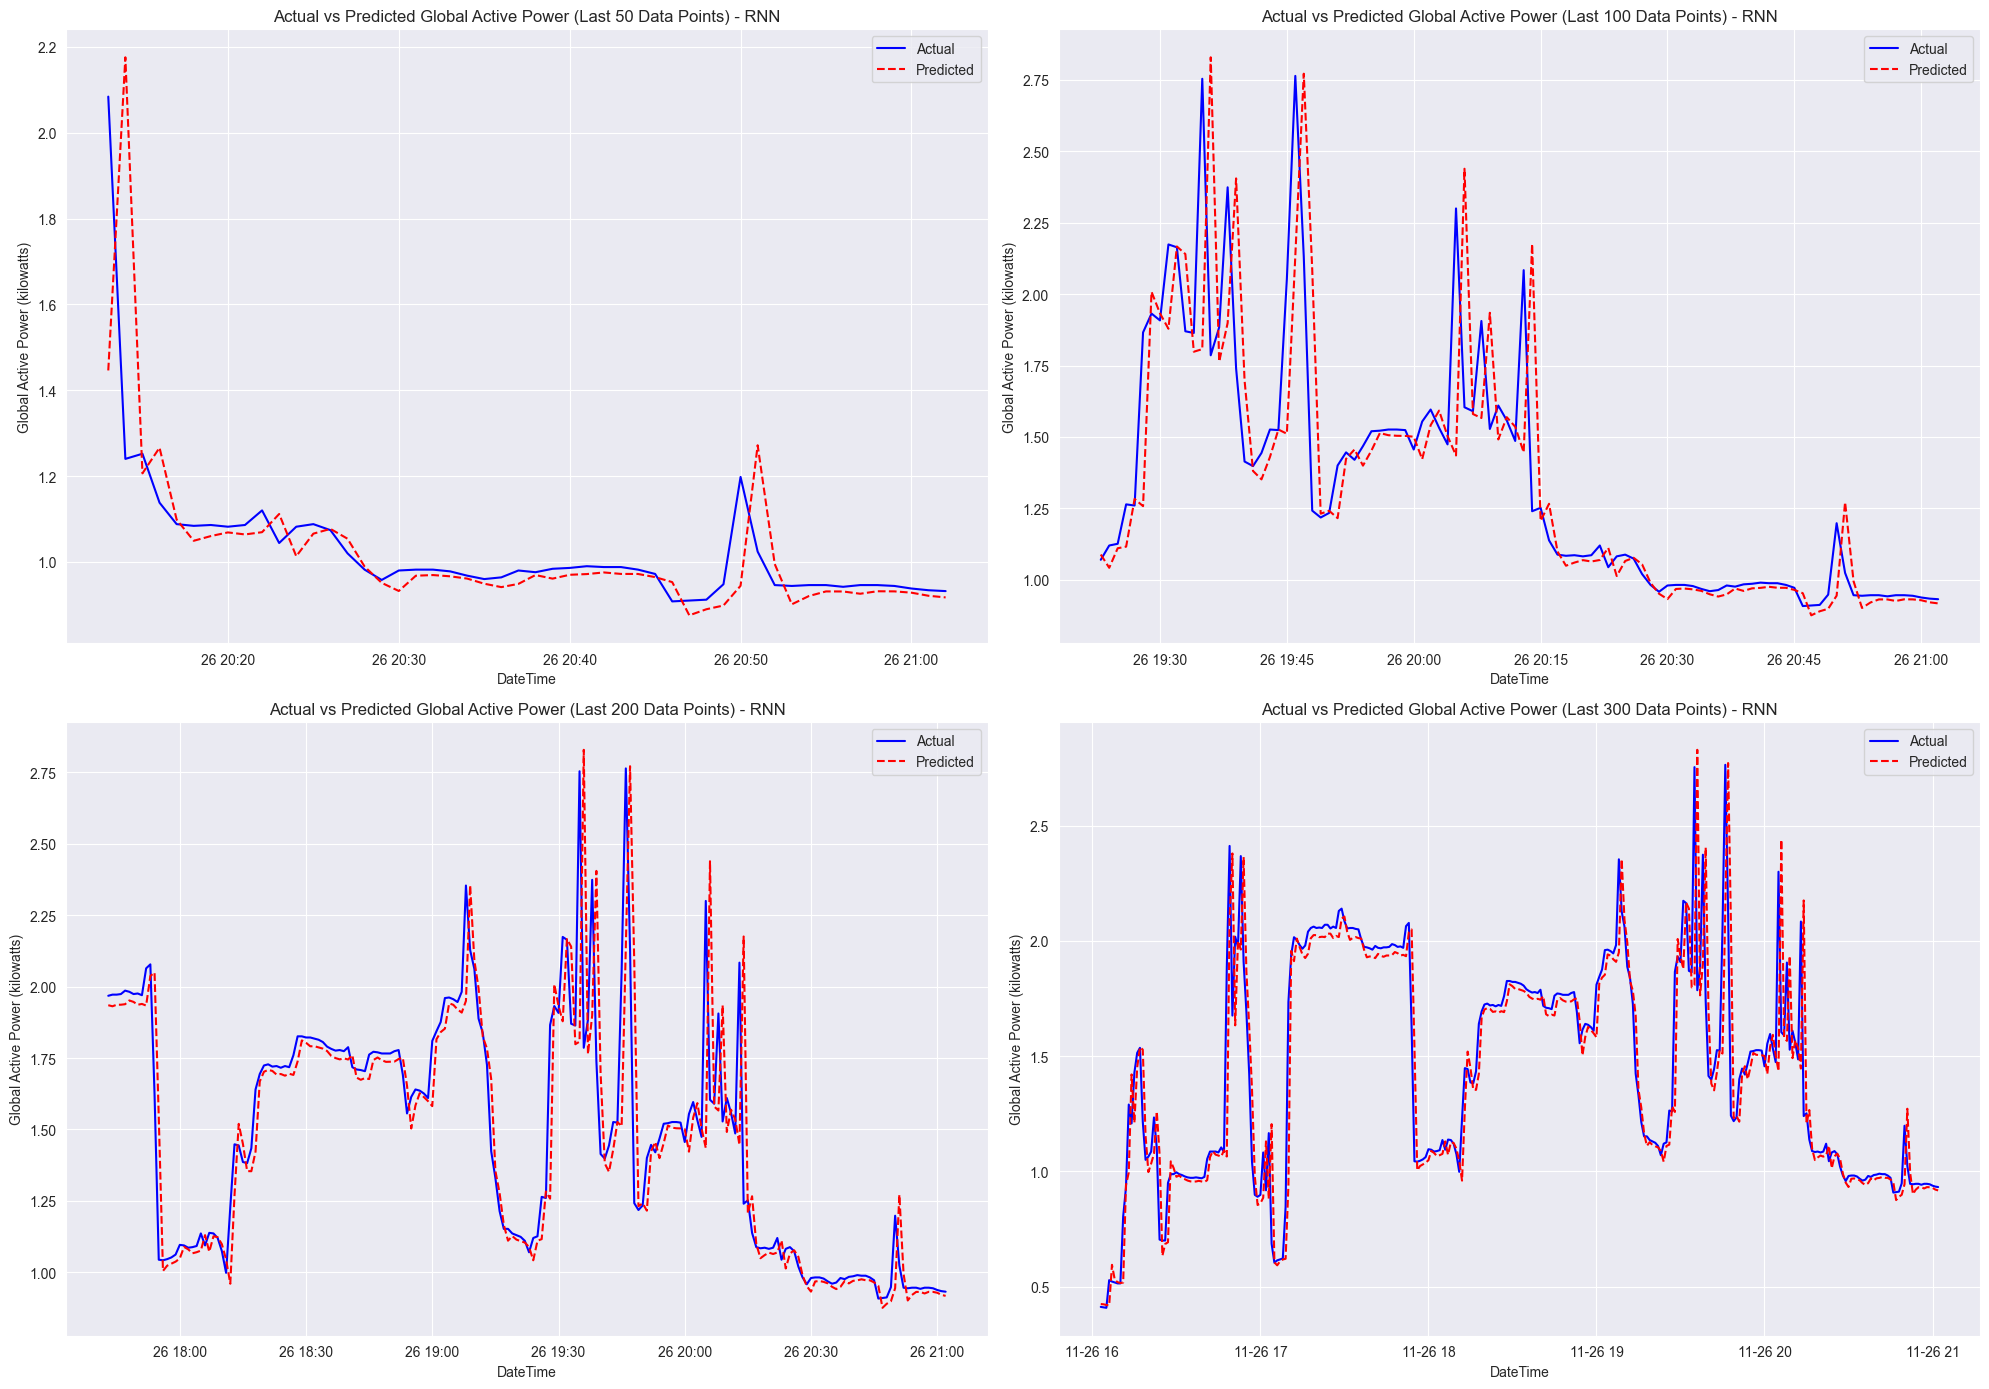

MSE: 0.04532789314264773
MAE: 0.08217937179659998
RMSE: 0.21290348316231872
R²: 0.9413137038118313


In [132]:
# Function to reshape data for RNN input
def reshape_data_for_rnn(X_train, X_test):
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    return X_train_reshaped, X_test_reshaped

# Function to prepare features and train RNN model
def train_and_evaluate_rnn(df, target_column, lags, resample_freq='D', epochs=10, batch_size=32):
    # Ensure DataFrame index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    # Resample data
    resampled_df = resample_data(df, resample_freq)
    
    # Create lagged features
    columns_selected = ['Global_active_power']
    processed_df = create_lagged_features(resampled_df, columns_selected, lags)
    
    # Drop unwanted columns
    columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
    columns_to_drop = [col for col in columns_to_drop if col in processed_df.columns]
    processed_df = processed_df.drop(columns=columns_to_drop)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(processed_df, target_column)
    
    # Reshape data for RNN input
    X_train_reshaped, X_test_reshaped = reshape_data_for_rnn(X_train, X_test)
    
    # Build RNN model
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    
    # Train RNN model
    rnn_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Make predictions
    y_pred = rnn_model.predict(X_test_reshaped)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, rmse, r2, y_test, y_pred



# Define parameters
target_column = 'Global_active_power'
lags = 3
resample_freq = ('h')  # Change this to 'T', 'H', 'D', 'W', 'min' as needed

# Train and evaluate RNN model
mse, mae, rmse, r2, y_test, y_pred = train_and_evaluate_rnn(power_consumption_df_no_missing, target_column, lags, resample_freq)
plot_actual_vs_predicted(y_test, y_pred, 'RNN')

# Print results
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# LSTM #
***

C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.287827318034798
MAE: 0.38427497212756306
RMSE: 0.5364954035542131
R²: 0.4610701220976505


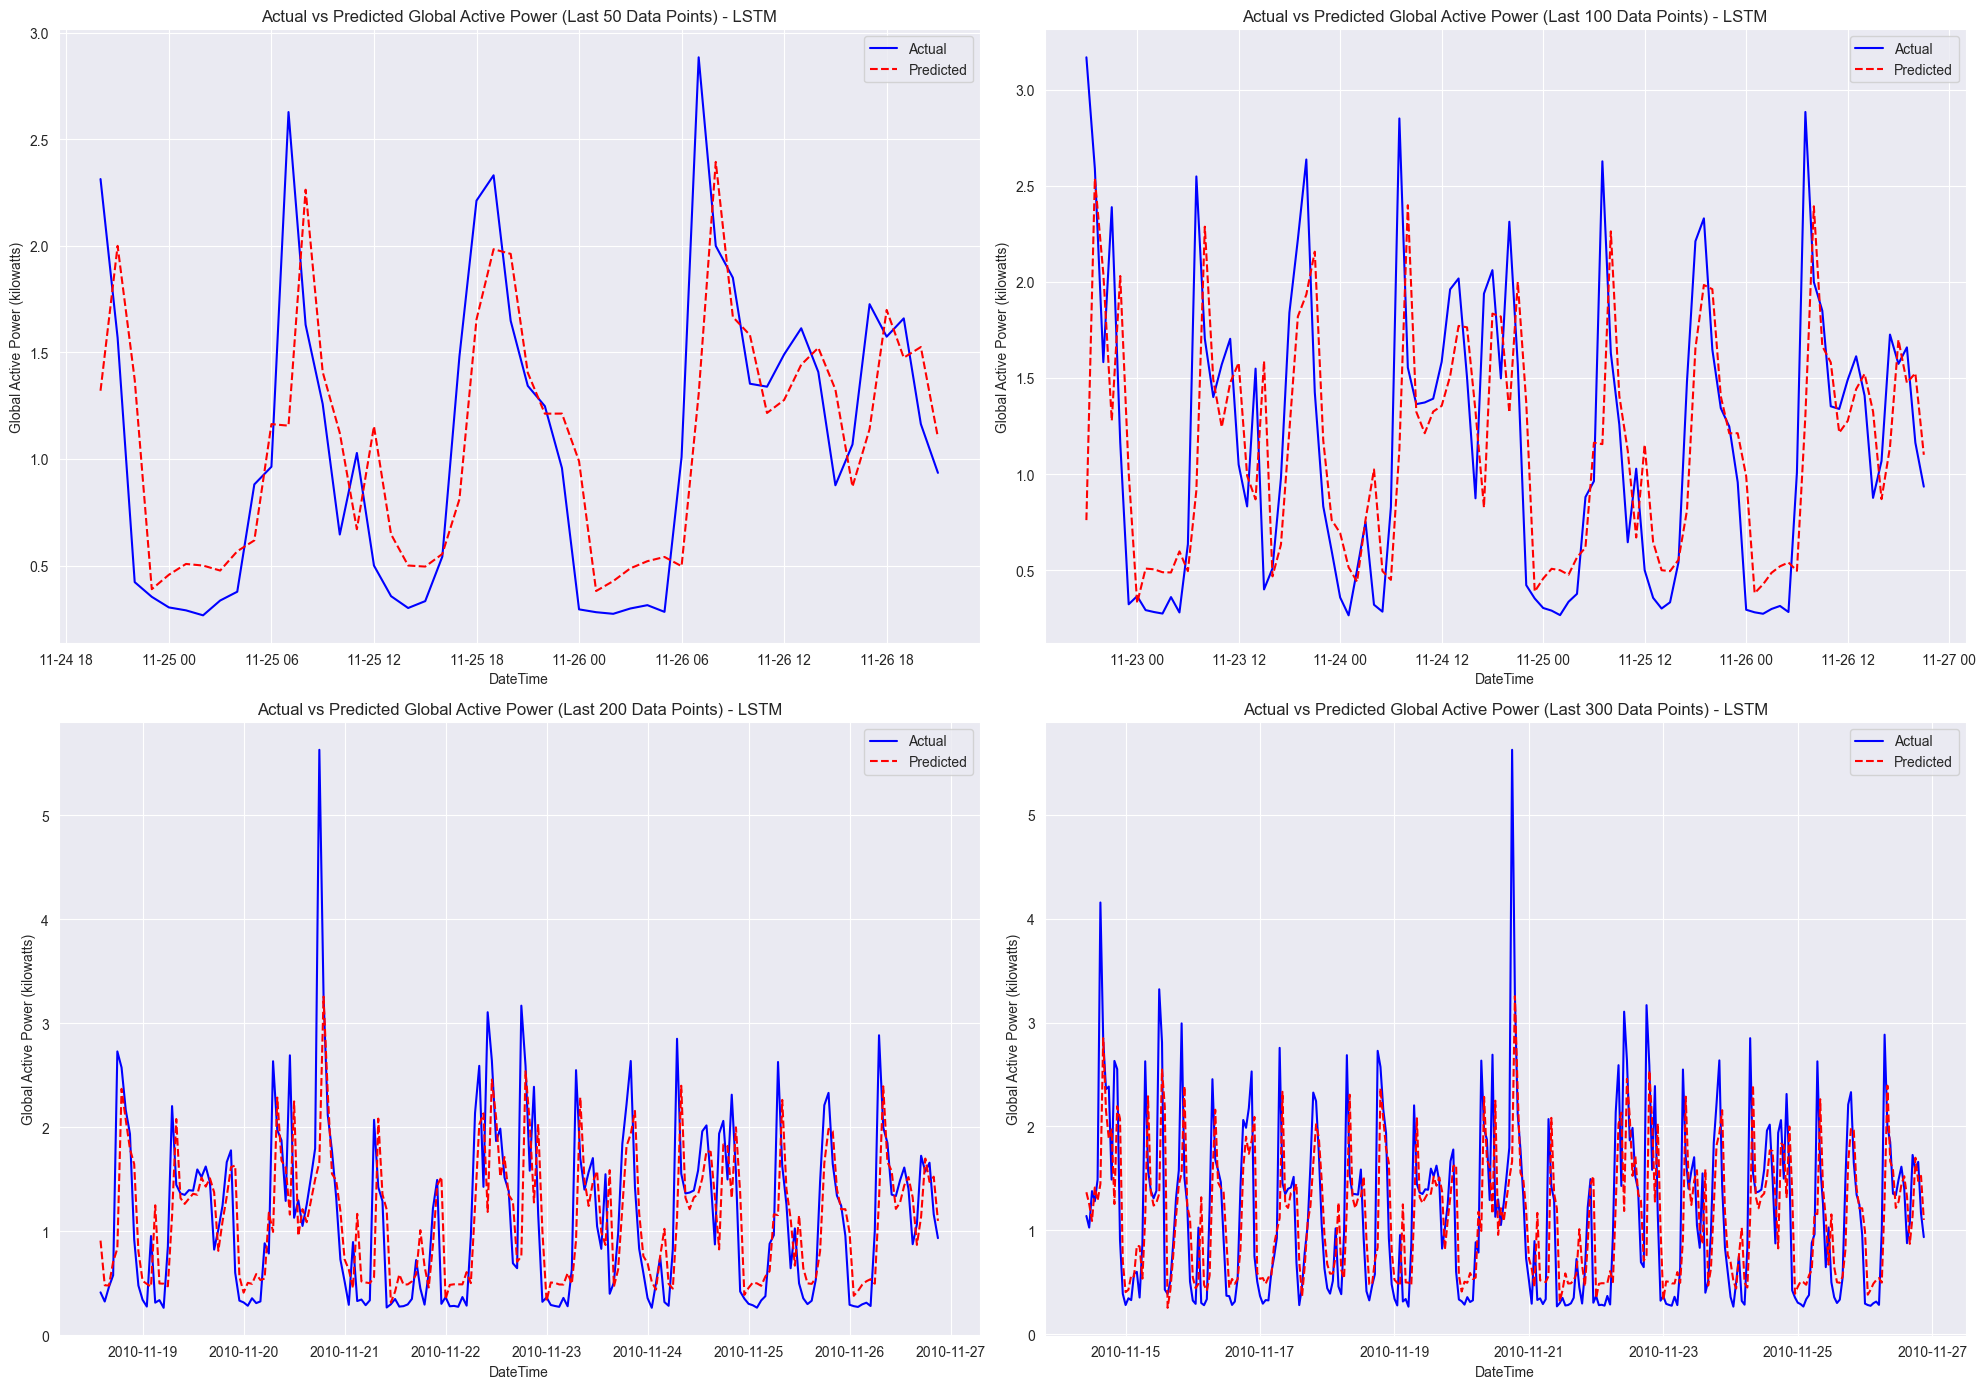

In [133]:
# Function to reshape data for LSTM input
def reshape_data_for_lstm(X_train, X_test):
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    return X_train_reshaped, X_test_reshaped

# Function to prepare features and train LSTM model
def train_and_evaluate_lstm(df, target_column, lags, resample_freq='D', epochs=10, batch_size=32):
    # Ensure DataFrame index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be of datetime type")

    # Resample data
    resampled_df = resample_data(df, resample_freq)
    
    # Create lagged features
    columns_selected = ['Global_active_power']
    processed_df = create_lagged_features(resampled_df, columns_selected, lags)
    
    # Drop unwanted columns
    columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
    columns_to_drop = [col for col in columns_to_drop if col in processed_df.columns]
    processed_df = processed_df.drop(columns=columns_to_drop)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(processed_df, target_column)
    
    # Reshape data for LSTM input
    X_train_reshaped, X_test_reshaped = reshape_data_for_lstm(X_train, X_test)
    
    # Build LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Train LSTM model
    lstm_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Make predictions
    y_pred = lstm_model.predict(X_test_reshaped)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, rmse, r2, y_test, y_pred

# Define parameters
target_column = 'Global_active_power'
lags = 3
resample_freq = ('h')  # Change this to 'T', 'H', 'D', 'W', 'min' as needed

# Train and evaluate LSTM model
mse, mae, rmse, r2, y_test, y_pred = train_and_evaluate_lstm(power_consumption_df_no_missing, target_column, lags, resample_freq)
# Print results
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

plot_actual_vs_predicted(y_test, y_pred, 'LSTM')

# LSTM with Attention #
***

C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


135/217 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step

C:\Users\baraky\Desktop\personal\Data_Science\afeka\שנה א סימסטר ב\LAB2\EX2\venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.287827318034798
MAE: 0.37525662736141513
RMSE: 0.5367780332398676
R²: 0.46050214816170365


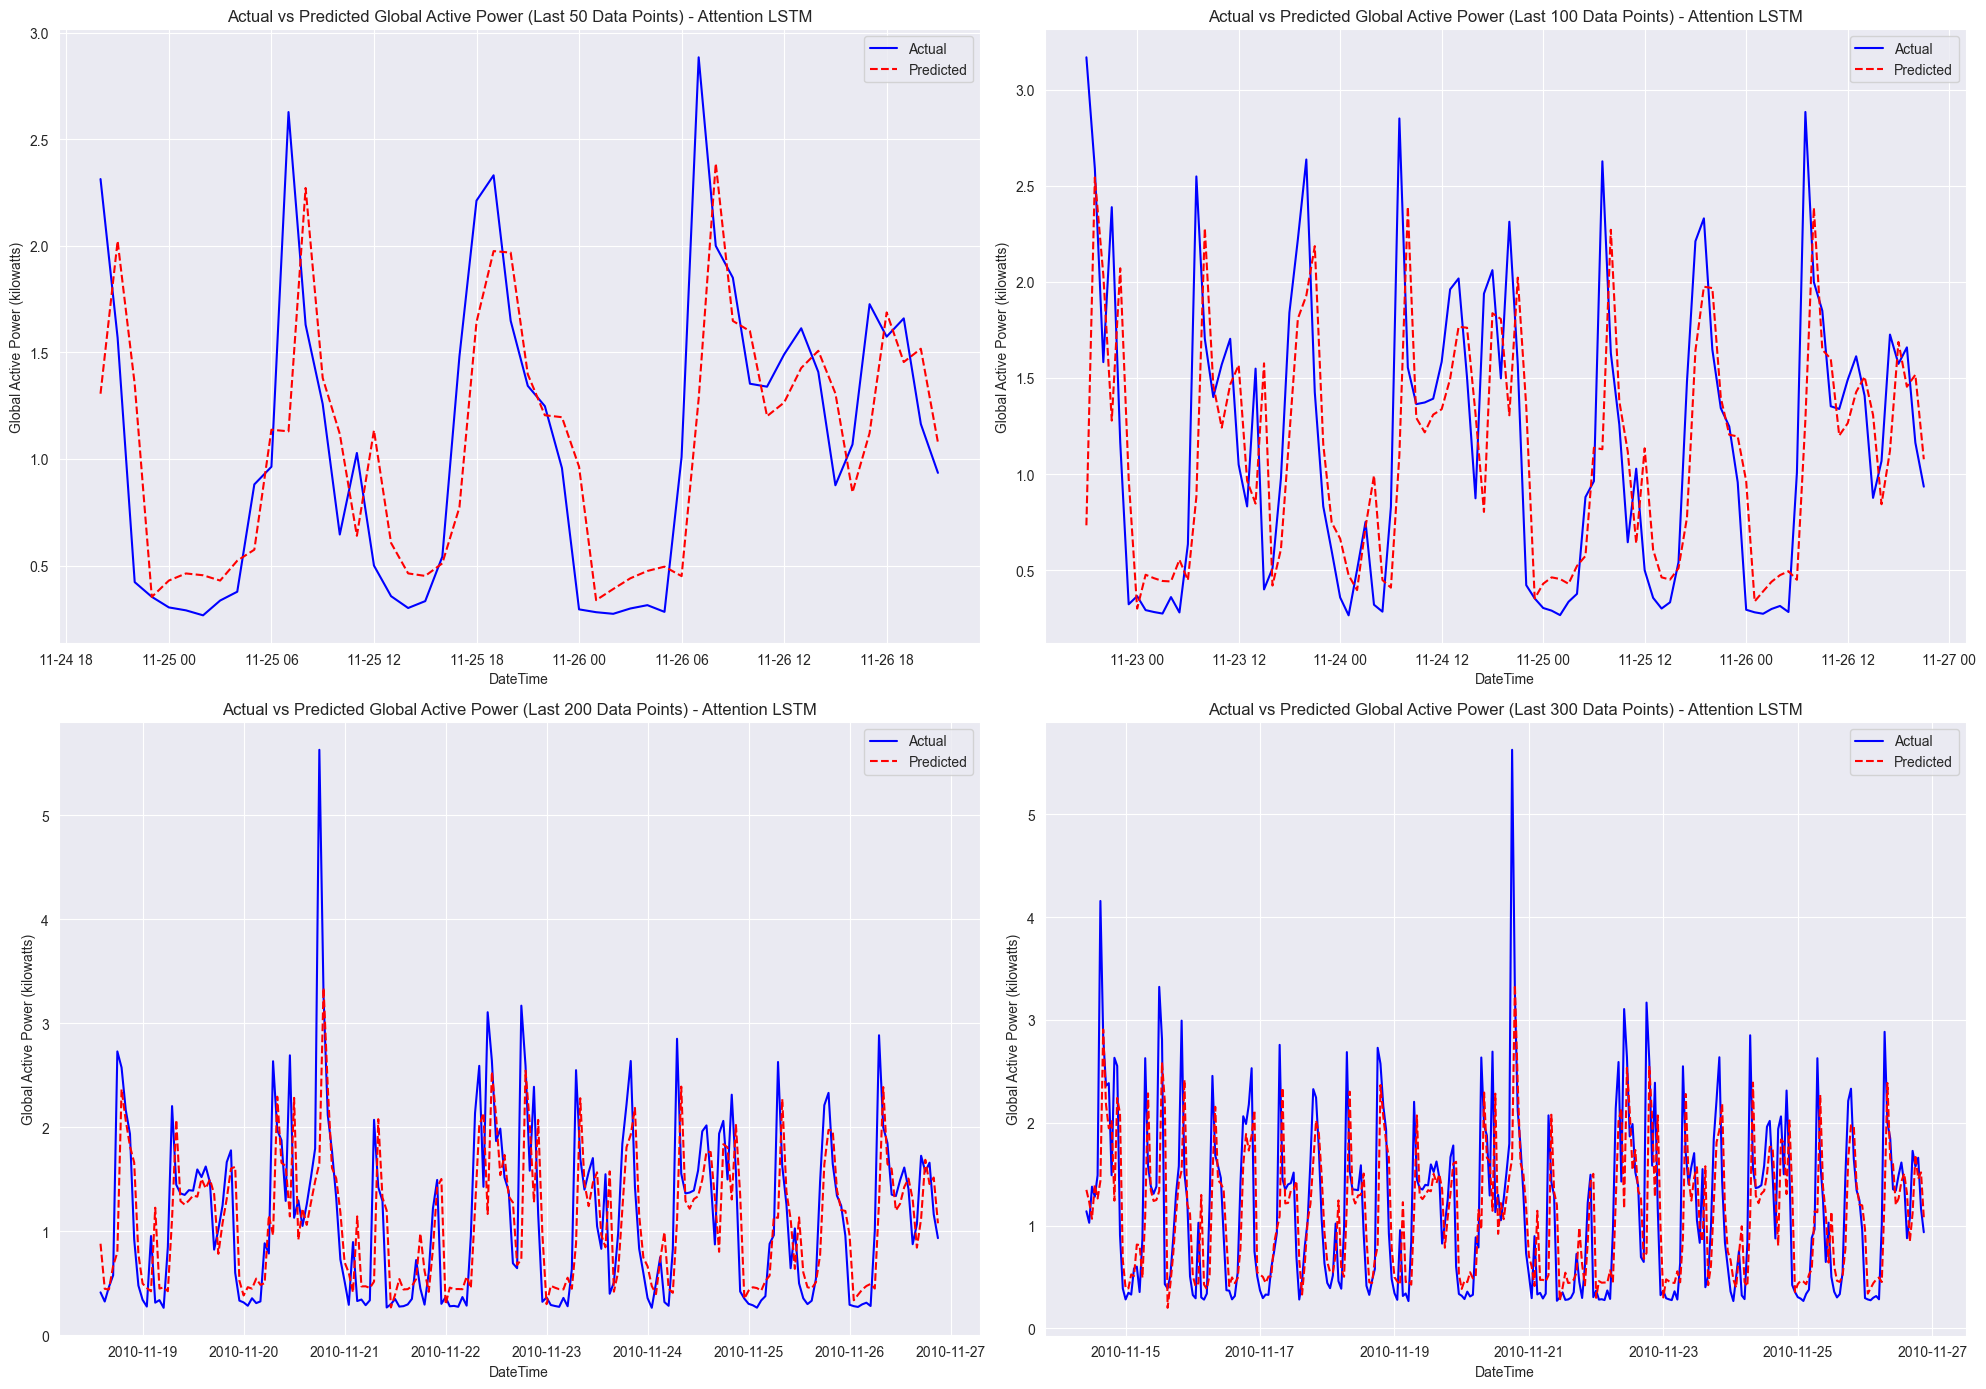

In [139]:


# Function to build and train an LSTM model with Attention
def train_and_evaluate_attention_lstm(df, target_column, lags, resample_freq='D', epochs=10, batch_size=32):
    # Resample data
    resampled_df = resample_data(df, resample_freq)
    
    # Create lagged features
    columns_selected = ['Global_active_power']
    processed_df = create_lagged_features(resampled_df, columns_selected, lags)
    
    # Drop unwanted columns
    columns_to_drop = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    columns_to_drop = [col for col in columns_to_drop if col in processed_df.columns]
    processed_df = processed_df.drop(columns=columns_to_drop)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(processed_df, target_column)
    
    # Reshape data for LSTM input
    X_train_reshaped, X_test_reshaped = reshape_data_for_rnn(X_train, X_test)
    
    # Build LSTM model with Attention
    input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    lstm_out, state_h, state_c = LSTM(50, return_sequences=True, return_state=True)(input_layer)
    attention = Attention()([lstm_out, lstm_out])
    context_vector = Concatenate(axis=-1)([attention, lstm_out])
    context_vector = Flatten()(context_vector)
    output = Dense(1)(context_vector)
    attention_lstm_model = Model(inputs=input_layer, outputs=output)
    attention_lstm_model.compile(optimizer='adam', loss='mse')
    
    # Train LSTM model with Attention
    attention_lstm_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Make predictions
    y_pred = attention_lstm_model.predict(X_test_reshaped)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, rmse, r2, y_test, y_pred

# Define parameters
target_column = 'Global_active_power'
lags = 3
resample_freq = ('h')  # Change this to 'T', 'H', 'D', 'W', 'min' as needed


mse_att_lstm, mae, rmse, r2, y_test, y_pred = train_and_evaluate_attention_lstm(power_consumption_df_no_missing, target_column, lags, resample_freq)

# Print results
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')
plot_actual_vs_predicted(y_test, y_pred, 'Attention LSTM')